## Neural Networks (2022-2023)
### Lab session 1: Logistic regression in PyTorch

In [1]:
import torch

#### Part 1: Tensor computations

In [2]:
# The PyTorch is syntax is very similar to NumPy, the main exception
# being requires_grad=True, meaning that all operations on X will be
# tracked in order to compute gradients.
torch.manual_seed(0)
X = torch.randn((3, 2), requires_grad=True)
X

tensor([[ 1.5410, -0.2934],
        [-2.1788,  0.5684],
        [-1.0845, -1.3986]], requires_grad=True)

In [3]:
# A tensor is described by its type and shape.
print(X.dtype)
print(X.shape)

torch.float32
torch.Size([3, 2])


In [4]:
# In addition, any tensor lives on a certain device, and operations
# are only possible for tensors staying on the same device (not an 
# issue for now).
X.device

device(type='cpu')

In [5]:
# No GPUs for the moment!
torch.cuda.device_count()

0

In [6]:
# In caso of a GPU, this is needed to send the tensor on the GPU.
# Otherwise, this can be specified in the constructor itself.
# X.to('cuda')

In [7]:
# Indexing is also almost identical to NumPy.
X[0:2]

tensor([[ 1.5410, -0.2934],
        [-2.1788,  0.5684]], grad_fn=<SliceBackward0>)

In [8]:
# Simple matrix multiplication
X @ X.T

tensor([[ 2.4608, -3.5243, -1.2609],
        [-3.5243,  5.0702,  1.5679],
        [-1.2609,  1.5679,  3.1323]], grad_fn=<MmBackward0>)

In [9]:
# Reshaping converts the tensor to a new tensor having a different shape.
# In some cases, it is possible to use a more efficient view operation, provided
# the view is compatible with the underlying data storage: 
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view
y = X.reshape((1, 6))
y

tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845, -1.3986]],
       grad_fn=<ReshapeAliasBackward0>)

In [10]:
# Broadcasting can also be used in PyTorch:
# https://pytorch.org/docs/stable/notes/broadcasting.html
z = torch.ones((3,6))
print(z)
(y + z)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


tensor([[ 2.5410,  0.7066, -1.1788,  1.5684, -0.0845, -0.3986],
        [ 2.5410,  0.7066, -1.1788,  1.5684, -0.0845, -0.3986],
        [ 2.5410,  0.7066, -1.1788,  1.5684, -0.0845, -0.3986]],
       grad_fn=<AddBackward0>)

In [11]:
# Double broadcasting!
(y + y.T)

tensor([[ 3.0820,  1.2476, -0.6378,  2.1094,  0.4565,  0.1424],
        [ 1.2476, -0.5869, -2.4722,  0.2750, -1.3780, -1.6920],
        [-0.6378, -2.4722, -4.3576, -1.6104, -3.2633, -3.5774],
        [ 2.1094,  0.2750, -1.6104,  1.1369, -0.5161, -0.8302],
        [ 0.4565, -1.3780, -3.2633, -0.5161, -2.1690, -2.4831],
        [ 0.1424, -1.6920, -3.5774, -0.8302, -2.4831, -2.7972]],
       grad_fn=<AddBackward0>)

In [12]:
# Reductions operate on the entire tensor by default,
# unless a dimension is specified.
print(X)
X.mean(dim=0)

tensor([[ 1.5410, -0.2934],
        [-2.1788,  0.5684],
        [-1.0845, -1.3986]], requires_grad=True)


tensor([-0.5741, -0.3745], grad_fn=<MeanBackward1>)

#### Part 2: Automatic differentiation

In [13]:
# Anything is okay here, provided the output is a scalar.
y = ((X.cos()) @ X.T**2).sum()
y

tensor(4.0480, grad_fn=<SumBackward0>)

In [14]:
# The grad_fn property allows to reconstruct the computational graph.
y

tensor(4.0480, grad_fn=<SumBackward0>)

In [15]:
# This will compute all gradients of y w.r.t. tensors involved in its computation
# that have requires_grad = True.
print(y.backward())

None


In [16]:
# Gradients are accumulated inside the grad property of the tensors.
X.grad

tensor([[-8.5226, -0.4728],
        [ 7.1338,  0.9679],
        [ 7.4968, -3.1840]])

In [17]:
# Equivalent to the above instruction, but gradients are returned.
# torch.autograd.grad(y, [X])

In [18]:
# The computational graph is freed after the first backward call.
# Running it again is impossible, try it.
# y.backward()

In [19]:
# If you do not want some operation to be traced, you need to include
# it in a proper no_grad context.
with torch.no_grad():
  y = X.sum()

In [20]:
y.grad_fn

#### Part 3: Logistic regression

In [21]:
# We will use the TensorFlow datasets repository for fun.
import tensorflow_datasets as tfds

In [22]:
# You can see the load documentation here: https://www.tensorflow.org/datasets
# The dataset itself is described here: https://www.tensorflow.org/datasets/catalog/penguins
penguins = tfds.load('penguins', as_supervised=True, split='train')

2023-06-13 14:36:02.253694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 14:36:03.469856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-13 14:36:04.327311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [23]:
# By default, the Dataset object is an iterator over the elements.
# The instructions below extract the underlying tensors.
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [24]:
# One row is an example, one column a feature of the input.
X.shape

(334, 4)

In [25]:
X[0]

array([0.6545454 , 0.22619048, 0.89830506, 0.6388889 ], dtype=float32)

In [26]:
y.shape

(334,)

In [27]:
# We split in a training set and a test set using the train_test_split utility from sklearn.
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [28]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [29]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

In [30]:
def init():
  # This initializes all parameters for the logistic regression model.
  # Note the requires_grad = True on both.
  W = torch.randn((4, 3), requires_grad=True)
  b = torch.randn((3,), requires_grad=True)
  return W, b

In [31]:
def logreg(X, W, b):
  """ A logistic regression model.
  Inputs:
  - X (n, 4): input matrix for the model.
  - W (4, 3): weight matrix.
  - b (3,): bias vector.

  Returns a (n, 3) output.
  """
  return torch.softmax(X @ W + b, 1)

In [32]:
W, b = init()
logreg(Xtrain, W, b)[0]

tensor([0.2125, 0.3787, 0.4088], grad_fn=<SelectBackward0>)

In [33]:
def cross_entropy(ytrue, ypred):
  """ Cross-entropy loss.
  Inputs:
  - ytrue (n,): vector of indices for the correct class.
  - ypred (n, 3): predictions of the model.
  Returns the average cross-entropy.
  """
  # This is called integer array indexing in NumPy:
  # https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [34]:
ypred = logreg(Xtrain, W, b)
cross_entropy(ytrain, ypred)

tensor(1.3616, grad_fn=<NegBackward0>)

In [35]:
# To understand better the indexing operation above, this is an example of how it results.
ypred[[0, 1, 2], [2, 0, 0]]

tensor([0.4088, 0.2158, 0.1560], grad_fn=<IndexBackward0>)

In [36]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [37]:
accuracy(ytrain, ypred)

tensor(0.2440)

In [38]:
W, b = init()

In [39]:
losses = []
accuracies = []

for i in range(5000):

  # Compute predictions
  ypred = logreg(Xtrain, W, b)

  # Compute the loss
  loss = cross_entropy(ytrain, ypred)

  # Compute the gradients
  loss.backward()

  with torch.no_grad():
    
    # Apply gradients 
    W -= 0.01*W.grad
    b -= 0.01*b.grad

    # Gradients are accumulated: we need to zero them out before the next iteration.
    W.grad.zero_()
    b.grad.zero_()

    losses.append(loss.detach().item())
    accuracies.append(accuracy(ytrain, ypred).item())

In [40]:
import matplotlib.pyplot as plt

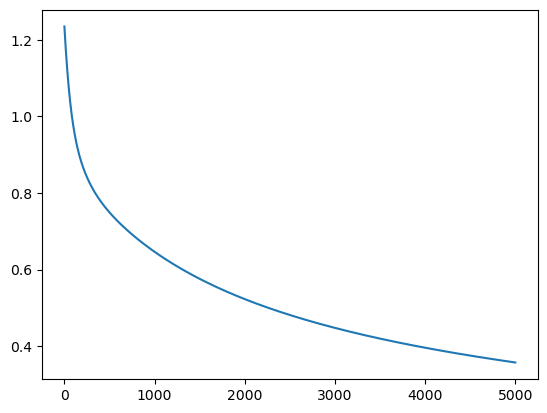

In [41]:
plt.plot(losses)

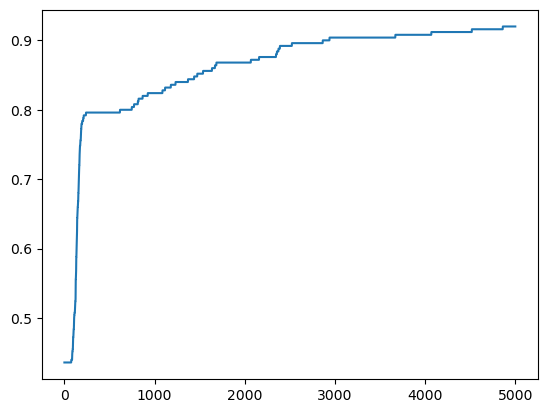

In [42]:
plt.plot(accuracies)

#### Exercises

1. We have not used the test portion of the dataset, modify the training loop to include tracking of test loss and test accuracy.

2. Add more metrics to be tracked, e.g., multi-class F1-score. The torchmetrics package has a lot of options in this sense: https://torchmetrics.readthedocs.io/en/stable/.

3. Momentum is a simple technique to improve the convergence speed of gradient descent. The key idea is to update each variable using a weighted average of the current gradient, and the gradient at the previous iteration (see Section 12.6 in the book). The weighting parameter is called the momentum weight. Implement momentum in the codelab, using a weight of 0.5.